In [1]:
import json

# Load datasets

In [2]:
rubq = json.load(open('../data/preprocessed/rubq/rubq_train.json'))['dataset']
qald = json.load(open('../data/preprocessed/qald/qald_train.json'))['dataset']
pat = json.load(open('../data/preprocessed/pat/pat_train.json'))['dataset']
lcquad = json.load(open('../data/preprocessed/lcquad_2.0/lcquad_2.0_train.json'))['dataset']

# Search relations

In [3]:
rel_stats = {}

for item in rubq:
    for rel_id in item['relations']['query'].keys():
        rel_stats[rel_id] = rel_stats.get(rel_id, []) + [item['en_question']]

In [4]:
rel_stats['P828']

['What can cause a tsunami?',
 'Who is the causative agent of sleeping sickness?']

# Similarity methods

## Transformers

In [44]:
import torch
import pandas as pd
import plotly.express as px
from scipy.spatial.distance import cosine
from transformers import BertTokenizer, BertTokenizerFast, BertModel

In [45]:
model_name = "bert-base-uncased"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_attentions=True, attn_implementation="eager")
model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

### Approach 1 Atteniton (Key-Query)

In [50]:
def get_query_key(sentence, model, tokenizer, layer_index=None):
    # Step 1. Pre-split the sentence into words.
    # (You may use a more sophisticated tokenizer if needed.)
    words = sentence.split()
    
    # Step 2. Tokenize using a fast tokenizer.
    # Using is_split_into_words=True ensures that we can later map subword tokens back to words.
    inputs = tokenizer(words,
                       is_split_into_words=True,
                       return_tensors="pt",
                       return_offsets_mapping=True)
    # word_ids() returns a list of word indices for each token.
    word_ids = inputs.word_ids(0)  # for the first (and only) sequence in the batch
    inputs.pop("offset_mapping")

    # Step 3. Run the model with hidden states enabled.
    outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states  # tuple: (embeddings, layer1, layer2, ..., layerN)

    if not layer_index:
        layer_index = len(hidden_states) - 2
            
    hidden_state_input = hidden_states[layer_index]  # shape: (batch_size, seq_len, hidden_size)

    # Access the self-attention module for the selected layer.
    attn_module = model.encoder.layer[layer_index].attention.self

    # Compute query and key vectors.
    # Under the hood, these are computed as: Q = X * W_Q + b_Q,  K = X * W_K + b_K.
    query = attn_module.query(hidden_state_input)  # shape: (batch_size, seq_len, hidden_size)
    key   = attn_module.key(hidden_state_input)    # shape: (batch_size, seq_len, hidden_size)

    # Step 4. Reshape to separate heads and then concatenate all heads.
    num_heads = attn_module.num_attention_heads
    head_dim = query.size(-1) // num_heads  # e.g., 768/12 = 64 for bert-base-uncased
    query = query.view(query.size(0), query.size(1), num_heads, head_dim)
    key   = key.view(key.size(0), key.size(1), num_heads, head_dim)
    # Concatenate heads: result is shape (seq_len, num_heads * head_dim)
    query_all = query[0].reshape(query.size(1), -1)
    key_all   = key[0].reshape(key.size(1), -1)

    # Step 5. Aggregate subword tokens into one vector per word.
    # We'll average the vectors for tokens belonging to the same word.
    agg_query_list = []
    agg_key_list   = []
    aggregated_words = []
    # The word_ids list has one entry per token; tokens with word_ids==None are special tokens.
    # Loop over unique word indices (which should be 0, 1, 2, ... in order).
    for word_index in range(len(words)):
        # Find the indices (positions) of tokens corresponding to this word.
        indices = [i for i, wid in enumerate(word_ids) if wid == word_index]
        if indices:
            # Average the query vectors for these subword tokens.
            agg_query = query_all[indices, :].mean(dim=0)
            agg_key   = key_all[indices, :].mean(dim=0)
            agg_query_list.append(agg_query)
            agg_key_list.append(agg_key)
            aggregated_words.append(words[word_index])
    
    # Stack into tensors of shape (num_words, total_dim)
    agg_query = torch.stack(agg_query_list, dim=0)
    agg_key   = torch.stack(agg_key_list, dim=0)
    
    return agg_query, agg_key, aggregated_words

In [51]:
# sentence1 = 'What can cause a tsunami?'
# sentence2 = 'Who is the causative agent of sleeping sickness?'
sentence1 = 'Who wrote the novel "uncle Tom\'s Cabin"?'
sentence2 = 'Who is the author of the play "Romeo and Juliet"?'

layer_index = -1

query1, key1, tokens1 = get_query_key(sentence1, model, tokenizer, layer_index=layer_index)
query2, key2, tokens2 = get_query_key(sentence2, model, tokenizer, layer_index=layer_index)

scores = (torch.matmul(query1, key2.transpose(0, 1)) / (query1.size(-1) ** 0.5)).detach().numpy()

sim_matrix_1 = (torch.matmul(query1, key2.transpose(0, 1)) / (query1.size(-1) ** 0.5)).detach().numpy()
sim_matrix_2 = (torch.matmul(query2, key1.transpose(0, 1)) / (query2.size(-1) ** 0.5)).detach().numpy()

sim_matrix_avg = 0.5 * (sim_matrix_1 + sim_matrix_2.T)

R1 = (query1 + key1) / 2  
R2 = (query2 + key2) / 2 
sim_matrix_R = torch.matmul(R1, R2.transpose(0, 1)) / (R2.size(-1) ** 0.5)  # or use cosine similarity 

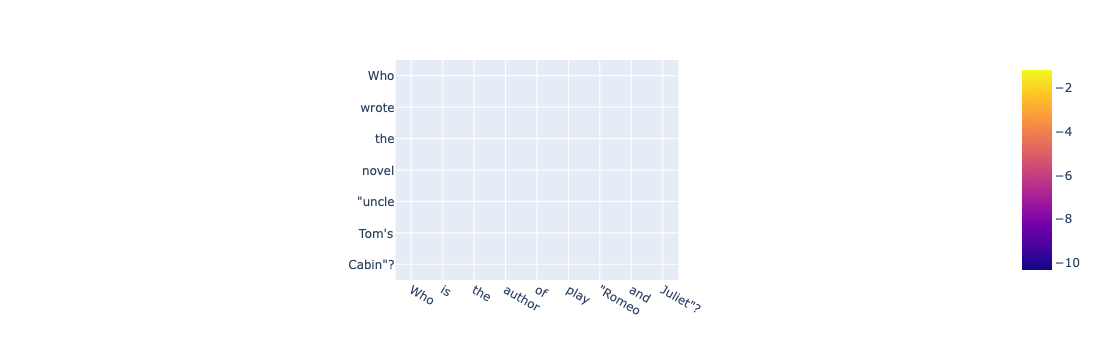

In [52]:
table = pd.DataFrame(scores, index=tokens1, columns=tokens2)
px.imshow(table)

### Approach 2 (Embedding similarity)

In [48]:
# sentence1 = "What can cause a tsunami?"
# sentence2 = "Who is the causative agent of sleeping sickness?"

sentence1 = 'Who wrote the novel "uncle Tom\'s Cabin"?'
sentence2 = 'Who is the author of the play "Romeo and Juliet"?'


# Split sentences into words
words1 = sentence1.split()
words2 = sentence2.split()

# Tokenize with word-level control
inputs1 = tokenizer(words1, is_split_into_words=True, return_tensors="pt", return_offsets_mapping=True)
inputs2 = tokenizer(words2, is_split_into_words=True, return_tensors="pt", return_offsets_mapping=True)

word_ids1 = inputs1.word_ids(0)  # Word mapping for sentence1
word_ids2 = inputs2.word_ids(0)  # Word mapping for sentence2

# Remove offset mapping
inputs1.pop("offset_mapping")
inputs2.pop("offset_mapping")

# Get BERT embeddings
with torch.no_grad():
    outputs1 = model(**inputs1)
    outputs2 = model(**inputs2)

# Extract last hidden state
embeddings1 = outputs1.last_hidden_state.squeeze(0)
embeddings2 = outputs2.last_hidden_state.squeeze(0)

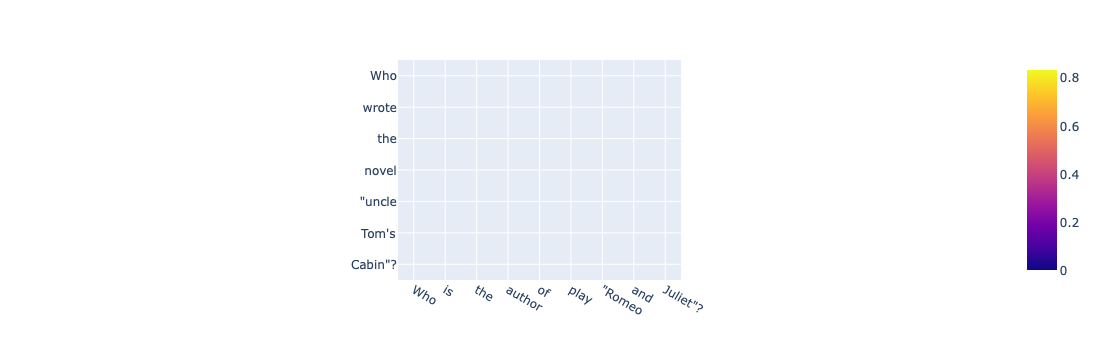

In [49]:
table = np.empty((len(words1), len(words2)))

for word1 in words1:
    for word2 in words2:
        idx1 = words1.index(word1)
        idx2 = words2.index(word2)

        embedding1 = embeddings1[word_ids1.index(idx1)].numpy()
        embedding2 = embeddings2[word_ids2.index(idx2)].numpy()
        
        table[idx1][idx2] = 1 - cosine(embedding1, embedding2)


table = pd.DataFrame(table, index=words1, columns=words2)
px.imshow(table)

## Pair-Wise

In [20]:
import nltk
import string
import Levenshtein
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, LancasterStemmer

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/amalekseev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [35]:
def tokenize_words(text):
    words = word_tokenize(text)  # Tokenize words
    words = [word.lower() for word in words if word.isalpha()]  # Remove punctuation & lowercase
    return words

def compare_sentences(sentence1, sentence2, compare, **kwargs):
    words1 = tokenize_words(sentence1)
    words2 = tokenize_words(sentence2)

    table = pd.DataFrame()
    
    for word1 in words1:
        for word2 in words2:
            table.loc[word1, word2] = compare(word1, word2, **kwargs)

    return table

def stemm_compare(word1, word2, stemmer):
    # porter = PorterStemmer()
    # lancaster = LancasterStemmer()
    return (stemmer.stem(word1) == stemmer.stem(word2)) * 1

def jaccard_similarity(word1, word2, n=2):
    """Computes Jaccard similarity based on character n-grams."""
    set1 = {word1[i:i+n] for i in range(len(word1)-n+1)}
    set2 = {word2[i:i+n] for i in range(len(word2)-n+1)}
    
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    
    return intersection / union if union != 0 else 0

def weighted_jaccard_similarity(word1, word2):
    return 0.3 * jaccard_similarity(word1, word2, n=2) +\
    0.4 * jaccard_similarity(word1, word2, n=3) +\
    0.3 * jaccard_similarity(word1, word2, n=4)

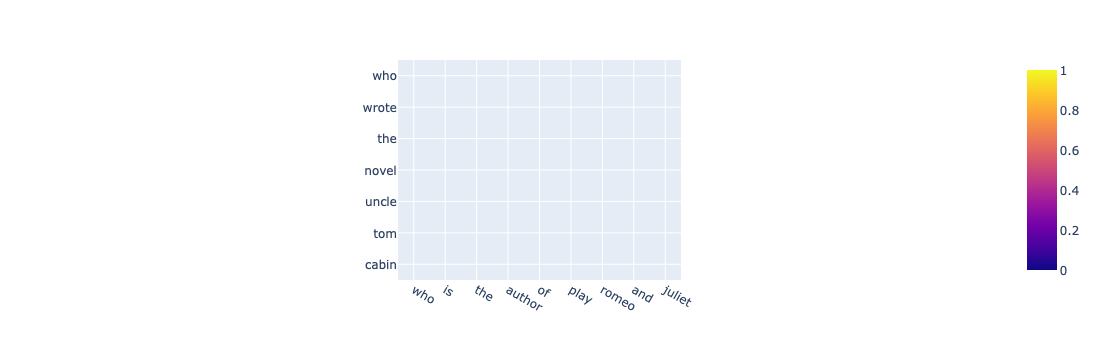

In [42]:
sentence1 = 'Who wrote the novel "uncle Tom\'s Cabin"?'
sentence2 = 'Who is the author of the play "Romeo and Juliet"?'

table = compare_sentences(sentence1, sentence2, stemm_compare, stemmer=PorterStemmer())
# table = compare_sentences(sentence1, sentence2, weighted_jaccard_similarity)

px.imshow(table)

## Word-Count

In [58]:
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [63]:
def tokenize_words(text, lemmatizer=lemmatizer):
    words = word_tokenize(text)  # Tokenize words
    words = [lemmatizer.lemmatize(word.lower()) for word in words if word.isalpha() and word.lower() not in stopwords.words('english')]
    return words
    
def count_sentence_stats(sentences):
    word_counts = Counter()
    
    for sentence in sentences:
        words = tokenize_words(sentence)
        word_counts.update(words)
    
    total_words = sum(word_counts.values())
    word_percentages = {word: (count / total_words) for word, count in word_counts.items()}
    
    return dict(sorted(word_percentages.items(), key=lambda item: item[1], reverse=True))

In [65]:
count_sentence_stats(rel_stats['P50'])

{'wrote': 0.08135593220338982,
 'author': 0.07457627118644068,
 'novel': 0.04406779661016949,
 'story': 0.023728813559322035,
 'writer': 0.020338983050847456,
 'poem': 0.01694915254237288,
 'fairy': 0.010169491525423728,
 'tale': 0.010169491525423728,
 'treatise': 0.010169491525423728,
 'history': 0.010169491525423728,
 'play': 0.006779661016949152,
 'word': 0.006779661016949152,
 'brutus': 0.006779661016949152,
 'belong': 0.006779661016949152,
 'work': 0.006779661016949152,
 'black': 0.006779661016949152,
 'man': 0.006779661016949152,
 'three': 0.006779661016949152,
 'created': 0.006779661016949152,
 'leicester': 0.006779661016949152,
 'code': 0.006779661016949152,
 'bill': 0.006779661016949152,
 'gate': 0.006779661016949152,
 'million': 0.006779661016949152,
 'told': 0.006779661016949152,
 'first': 0.006779661016949152,
 'short': 0.006779661016949152,
 'flower': 0.006779661016949152,
 'time': 0.006779661016949152,
 'book': 0.006779661016949152,
 'ancient': 0.006779661016949152,
 'jou

# Feature extraction

In [17]:
import requests
import json
import aiohttp

from linker_utils import fetch_multiple_entities, fetch_wikidata_entity_info

## Relation info

In [20]:
wikidata_relations = list(json.load(open('storage/list_of_wikidata_relations.json')).keys())

relations_info = {}

while len(wikidata_relations) > 0:
    prev_len = len(wikidata_relations)
    async with aiohttp.ClientSession() as session:
        successful_results, failed_entities = await fetch_multiple_entities(wikidata_relations, session)
        relations_info.update(successful_results)

    wikidata_relations = list(failed_entities.keys())

    if prev_len == len(wikidata_relations):
        print(f"Number of failed entities didn't reduced: {prev_len} ({wikidata_relations[0]}).")



10751 P1310
10075 P1474
9396 P1712
8763 P1960
8180 P2153
7623 P2181
7121 P2313
6676 P2467
6202 P2825
5783 P2868
5407 P3023
5015 P3050
4680 P3050
4341 P3213
4030 P3213
3752 P3213
3506 P3392
3248 P3664
2991 P3939
2756 P4158
2544 P4158
2383 P4158
2159 P5196
2015 P5203
1836 P5203


In [23]:
for relation_id, info in relations_info.items():
    if not info['label']:
        print(relation_id)

P1996
P1570
P1152
P940
P1849
P1646
P1223
P2035
P1222
P448
P1946
P1858
P2086
P1859
P1790
P1569
P796
P558
P1860
P907
P1432
P1231
P1865
P738
P438
P1863
P1773
P1655
P1861
P1124
P728
P9
P513
P2224
P794
P357
P1658
P43
P883
P387
P969
P44
P1688
P7
P1962
P1112
P1969
P857
P2237
P1856
P1805


# Pipeline

In [102]:
import spacy
from spacy.matcher import PhraseMatcher

# Example relation-to-keywords mapping.
relation_keywords = {
    "P828": ["cause", "causative", "induce", "trigger", "implied by"],
    "P1534": ["end cause", "final cause", "ultimate cause"],
    "P50":  ["wrote", "author", "written by", "who is the author"]
}

# Load spaCy language model.
nlp = spacy.load("en_core_web_sm")

# Initialize the PhraseMatcher.
matcher = PhraseMatcher(nlp.vocab, attr="LOWER")

# Add patterns for each relation.
for rel_id, keywords in relation_keywords.items():
    patterns = [nlp.make_doc(text) for text in keywords]
    matcher.add(rel_id, patterns)

def detect_relation_phrase(sentence):
    """
    Detects relation IDs from a sentence using spaCy's PhraseMatcher.
    """
    doc = nlp(sentence)
    matches = matcher(doc)
    found_relations = set()
    for match_id, start, end in matches:
        relation = nlp.vocab.strings[match_id]
        found_relations.add(relation)
    return list(found_relations)

# Test examples.
print(detect_relation_phrase("What can cause a tsunami?"))      # Expected: ['P828']
print(detect_relation_phrase("Who is the author of this book?"))   # Expected: ['P50']
print(detect_relation_phrase("The final cause of the event is unknown."))  # Expected: ['P1534']

/Users/amalekseev/anaconda3/lib/python3.11/site-packages/spacy/util.py:910: UserWarning:

[W095] Model 'en_core_web_sm' (3.5.0) was trained with spaCy v3.5.0 and may not be 100% compatible with the current version (3.8.3). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


['P828']
['P50']
['P1534', 'P828']
